In [ ]:
# !pip3 install pandas matplotlib

In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Time-decay модель.
Веса для модели расчитываются по формуле:

вес сессии = $2^{- d / s}$

где d — дней до покупки
s — количество сессий у пользователя

Почему такая формула? Давайте посмотрим на график функции

y = $2^{- x / s}$

Мы хотим увидеть, как меняется вес сессии в зависимости от 2 факторов:
- времени до сессии с покупкой
- количества сессий у пользователя

График выглядит так:

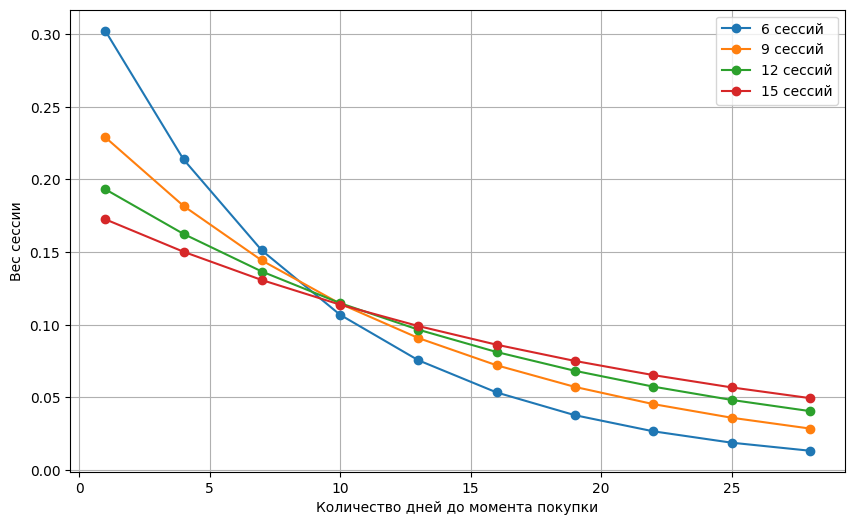

In [3]:
x = list(range(1, 31, 3))

plt.figure(figsize=(10, 6))

for s in range(6, 16, 3):
    w = [2**(-d / s) for d in x]
    y = [weight / sum(w) for weight in w]  # нормируем, чтобы сумма весов была равна 1
    plt.plot(x, y, '-o', label=f'{s} сессий')

plt.legend(loc='best')
plt.xlabel('Количество дней до момента покупки')
plt.ylabel('Вес сессии')
plt.grid()
plt.show()

По графику можно сделать следующие выводы:
- график — убывающая функция: чем больше дней до покупки (горизонтальная ось), тем меньше вес у соответствующей сессии
- если пользователь приходил нечасто, то есть у него мало сессий, то веса очень сильно убывают с течением времени
- если пользователь часто к нам приходил, то веса убывают относительно медленно

Именно для того, чтобы функция убывала с ростом количества дней до покупки, перед количеством дней в формуле стоит знак «минус».
А для того, чтобы регулировать скорость убывания функции, мы используем количество сессий в качестве делителя.

Важный вывод — если пользователь приходит к нам редко, то для нас очень ценны сессии непосредственно перед покупкой. И наоборот, давние сессии для редкого гостя имеют мало ценности для бизнеса.

In [ ]:
# если код выполняется в colab-ноутбуке, то замените первую строчку в следующей ячейке на эту:
# session_data = pd.read_csv('https://drive.google.com/file/d/1y1qm5nZFb89Muroe3nhcgboSTSX3ZJLi/view?usp=sharing')

In [8]:
session_data = pd.read_csv('data/data.csv', delimiter=';')

# изменение форматов данных для удобства
session_data['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in session_data['date']]
session_data[['cost', 'value']] = session_data[['cost', 'value']].astype(float)
session_data

,userId,date,trafficSource,cost,value
0,user_10,2020-01-05,telegram / posts,15.75,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0
2,user_10000,2020-01-19,google / cpc,8.25,0.0
3,user_1002,2020-01-03,telegram / posts,15.75,0.0
4,user_1003,2020-01-08,google / cpc,8.25,0.0
...,...,...,...,...,...
9995,user_999,2020-01-03,facebook / video,10.25,0.0
9996,user_9992,2020-01-04,google / cpc,8.25,0.0
9997,user_9995,2020-01-05,telegram / posts,15.75,0.0
9998,user_9995,2020-01-21,yandex / cpc,8.50,0.0


In [9]:
# группировка и суммирования, чтобы объединить покупки с одинакового канала в один день
# session_data = session_data.groupby(['userId', 'date', 'trafficSource'])['cost', 'value'].sum().reset_index()
session_data = session_data[['userId', 'date', 'trafficSource','cost', 'value']].groupby(['userId', 'date', 'trafficSource']).sum().reset_index()
# session_data = session_data[['userId', 'date', 'trafficSource', 'cost', 'value']].groupby(['userId', 'date', 'trafficSource']).agg('sum').reset_index()
# # session_data = session_data.groupby(['userId', 'date', 'trafficSource'])[['cost', 'value']].sum().reset_index()
# # session_data = session_data.groupby(['userId', 'date', 'trafficSource']).agg('sum').reset_index()
session_data = session_data.sort_values(by=['userId', 'date'])
session_data

,userId,date,trafficSource,cost,value
0,user_10,2020-01-05,telegram / posts,15.75,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0
2,user_10000,2020-01-19,google / cpc,8.25,0.0
3,user_1002,2020-01-03,telegram / posts,15.75,0.0
4,user_1003,2020-01-08,google / cpc,8.25,0.0
...,...,...,...,...,...
9899,user_999,2020-01-03,facebook / video,10.25,0.0
9900,user_9992,2020-01-04,google / cpc,8.25,0.0
9901,user_9995,2020-01-05,telegram / posts,15.75,0.0
9902,user_9995,2020-01-21,yandex / cpc,8.50,0.0


In [10]:
# таблица только с датами покупок, нужна для time-decay модели

purchases_only = session_data[session_data['value'] > 0][['userId', 'date']]
purchases_only = purchases_only.groupby('userId')['date'].max().reset_index()
purchases_only.columns = ['userId', 'purchaseDate']
purchases_only

,userId,purchaseDate
0,user_10,2020-01-05
1,user_1008,2020-01-09
2,user_1011,2020-01-09
3,user_1016,2020-01-15
4,user_1022,2020-01-03
...,...,...
821,user_9975,2020-01-08
822,user_9979,2020-01-08
823,user_9982,2020-01-30
824,user_9985,2020-01-10


In [11]:
# расчет вспомогательных колонок

session_data['totalSessions'] = session_data.groupby('userId')['date'].transform(lambda x: x.count())
session_data['totalValue'] = session_data.groupby('userId')['value'].transform(lambda x: x.sum())
session_data['sessionNumber'] = session_data.groupby('userId').cumcount() + 1

session_data = session_data.merge(purchases_only, on='userId', how='left')
session_data

,userId,date,trafficSource,cost,value,totalSessions,totalValue,sessionNumber,purchaseDate
0,user_10,2020-01-05,telegram / posts,15.75,215.0,1,215.0,1,2020-01-05
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0,2,0.0,1,NaT
2,user_10000,2020-01-19,google / cpc,8.25,0.0,2,0.0,2,NaT
3,user_1002,2020-01-03,telegram / posts,15.75,0.0,1,0.0,1,NaT
4,user_1003,2020-01-08,google / cpc,8.25,0.0,2,0.0,1,NaT
...,...,...,...,...,...,...,...,...,...
9899,user_999,2020-01-03,facebook / video,10.25,0.0,1,0.0,1,NaT
9900,user_9992,2020-01-04,google / cpc,8.25,0.0,1,0.0,1,NaT
9901,user_9995,2020-01-05,telegram / posts,15.75,0.0,2,0.0,1,NaT
9902,user_9995,2020-01-21,yandex / cpc,8.50,0.0,2,0.0,2,NaT


In [12]:
# расчет весов time-decay модели

session_data['daysToPurchase'] = [(x - y).days if x else 0
                                  for x, y in zip(session_data['purchaseDate'], session_data['date'])]

session_data['timeDecayWeight'] = [2**(-x / y)
                                   for x, y in zip(session_data['daysToPurchase'], session_data['totalSessions'])]

session_data['timeDecayWeight'] = session_data['timeDecayWeight'] / session_data.groupby('userId')['timeDecayWeight'].transform(lambda x: x.sum())
session_data


,userId,date,trafficSource,cost,value,totalSessions,totalValue,sessionNumber,purchaseDate,daysToPurchase,timeDecayWeight
0,user_10,2020-01-05,telegram / posts,15.75,215.0,1,215.0,1,2020-01-05,0.0,1.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0,2,0.0,1,NaT,NaN,NaN
2,user_10000,2020-01-19,google / cpc,8.25,0.0,2,0.0,2,NaT,NaN,NaN
3,user_1002,2020-01-03,telegram / posts,15.75,0.0,1,0.0,1,NaT,NaN,NaN
4,user_1003,2020-01-08,google / cpc,8.25,0.0,2,0.0,1,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9899,user_999,2020-01-03,facebook / video,10.25,0.0,1,0.0,1,NaT,NaN,NaN
9900,user_9992,2020-01-04,google / cpc,8.25,0.0,1,0.0,1,NaT,NaN,NaN
9901,user_9995,2020-01-05,telegram / posts,15.75,0.0,2,0.0,1,NaT,NaN,NaN
9902,user_9995,2020-01-21,yandex / cpc,8.50,0.0,2,0.0,2,NaT,NaN,NaN


In [13]:
# расчет выручки на основе различных моделей атрибуции

session_data['lastTouchValue'] = session_data['value']
session_data['firstTouchValue'] = [x if y == 1 else 0
                                   for x, y in zip(session_data['totalValue'], session_data['sessionNumber'])]
session_data['linearValue'] = session_data['totalValue'] / session_data['totalSessions']
session_data['timeDecayValue'] = session_data['totalValue'] * session_data['timeDecayWeight']
session_data


,userId,date,trafficSource,cost,value,totalSessions,totalValue,sessionNumber,purchaseDate,daysToPurchase,timeDecayWeight,lastTouchValue,firstTouchValue,linearValue,timeDecayValue
0,user_10,2020-01-05,telegram / posts,15.75,215.0,1,215.0,1,2020-01-05,0.0,1.0,215.0,215.0,215.0,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0,2,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
2,user_10000,2020-01-19,google / cpc,8.25,0.0,2,0.0,2,NaT,NaN,NaN,0.0,0.0,0.0,NaN
3,user_1002,2020-01-03,telegram / posts,15.75,0.0,1,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
4,user_1003,2020-01-08,google / cpc,8.25,0.0,2,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9899,user_999,2020-01-03,facebook / video,10.25,0.0,1,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
9900,user_9992,2020-01-04,google / cpc,8.25,0.0,1,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
9901,user_9995,2020-01-05,telegram / posts,15.75,0.0,2,0.0,1,NaT,NaN,NaN,0.0,0.0,0.0,NaN
9902,user_9995,2020-01-21,yandex / cpc,8.50,0.0,2,0.0,2,NaT,NaN,NaN,0.0,0.0,0.0,NaN


In [14]:
# проверка корректности расчетов

print(session_data[['lastTouchValue', 'firstTouchValue', 'linearValue', 'timeDecayValue']].sum())

lastTouchValue     131345.0
firstTouchValue    131345.0
linearValue        131345.0
timeDecayValue     131345.0
dtype: float64


In [15]:
# финальная таблица

totals = session_data.groupby('trafficSource')[['cost', 'lastTouchValue', 'firstTouchValue', 'linearValue',
                                                'timeDecayValue']].sum()

totals['lastTouchROI'] = 100*(round(totals['lastTouchValue'] / totals['cost'], 4))
totals['firstTouchROI'] = 100*(round(totals['firstTouchValue'] / totals['cost'], 4))
totals['linearROI'] = 100*(round(totals['linearValue'] / totals['cost'], 4))
totals['timeDecayROI'] = 100*(round(totals['timeDecayValue'] / totals['cost'], 4))

totals[['cost', 'lastTouchROI', 'firstTouchROI', 'linearROI', 'timeDecayROI']]

,cost,lastTouchROI,firstTouchROI,linearROI,timeDecayROI
trafficSource,,,,,
facebook / video,28208.00,119.59,136.65,123.62,121.08
google / cpc,25137.75,169.30,163.54,169.77,178.20
telegram / posts,35374.50,82.91,71.97,78.05,78.77
vk / display,4498.75,96.58,103.42,91.51,78.79
yandex / cpc,14025.00,152.42,153.83,157.36,149.64
